# PCA on Breast Ultra Sound Image

### Import packages

In [2]:
import os
import re
import random
from pathlib import Path
from pprint import pprint
import time
from sklearn.manifold import TSNE
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

### Read image list (with dict object for each image) for the 3 classes

In [3]:
img_res = 512

normal_img_dir = './Dataset_BUSI_with_GT/normal_512'
benign_img_dir = './Dataset_BUSI_with_GT/benign_512'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_512'

# Get a list of images in the images directory
normal_img_list_all = get_file_dicts(normal_img_dir)
num_normal_img = len(normal_img_list_all)
print(f"Number of images in normal dataset: {num_normal_img}")

benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in normal dataset: 133
Number of images in benign dataset: 437
Number of images in malignant dataset: 420


### Perform PCA

In [4]:
# Prepare data for the PCA

# Select n random samples from each list to show
nsample = 128

benign_img_list = random.sample(benign_img_list_all, nsample)
malignant_img_list = random.sample(malignant_img_list_all, nsample)

In [5]:
img_data = np.empty((0, img_res*img_res), np.float32)

# read and append image data to img_data
img_data = append_img_data(img_data, benign_img_list)
img_data = append_img_data(img_data, malignant_img_list)

# create targets - 0 for benign and 1 for malignant
img_target = np.array([0]*nsample, dtype= np.int32)
img_target = np.append(img_target, np.array([1]*nsample, dtype= np.int32))

print(img_data.shape)
print(img_target.shape)

(256, 262144)
(256,)


In [6]:
# Visualize just 2 components to see if 2 components alone can differentiate between the classes
pca = PCA(2)  # project from img_res x img_res components to just 2 components
projected = pca.fit_transform(img_data)
print(img_data.shape)
print(projected.shape)

(256, 262144)
(256, 2)


/home/ec2-user/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Discrimination ability using 2 PCA components')

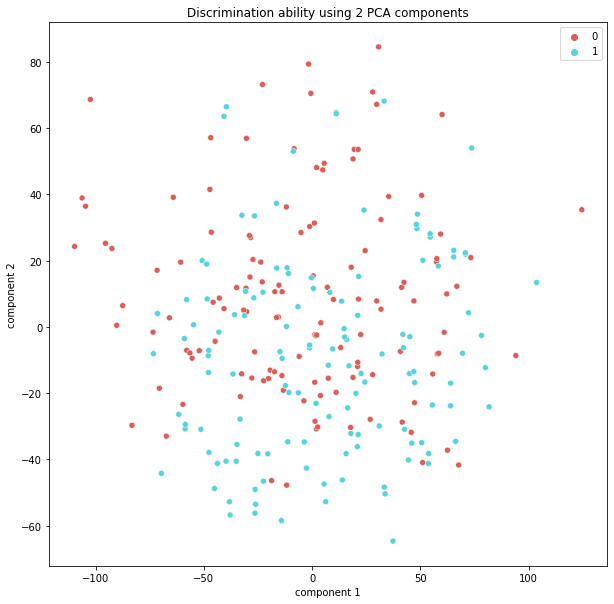

In [7]:
# Visualize the 2 PCA components against the 2 classes
plt.figure(figsize=(10,10))
sns.scatterplot(
    projected[:, 0], projected[:, 1],
    hue=img_target,
    palette=sns.color_palette("hls", 2),
    data=img_data,
    legend="full",
    alpha=1
)   
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Discrimination ability using 2 PCA components')

With our PCA bi-plot above, we can see that there really isn't much distinguising our malignant vs benign tumors. The malignant tumors seem to be on the lower end of the component 2 than the benign tumors, but other than that distinction, we don't see a lot of clustering from this plot.

99


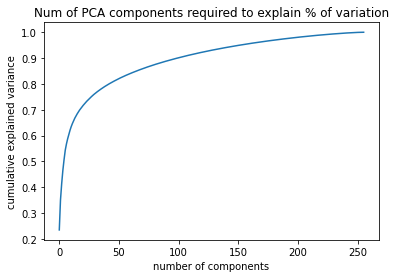

In [11]:
# How many components are required to explain 90% of variance. Visualize
pca = PCA().fit(img_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Num of PCA components required to explain % of variation')

variance = np.cumsum(pca.explained_variance_ratio_)
indices = np.argwhere(variance >= 0.9)
print(np.min(indices))

### Perform t-SNE visualization

In [9]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.048s...
[t-SNE] Computed neighbors for 256 samples in 3.855s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 35.087427
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.513191
[t-SNE] KL divergence after 300 iterations: 0.789644
t-SNE done! Time elapsed: 7.935365676879883 seconds


Text(0.5, 1.0, 'Discrimination ability using 2 t-SNE components')

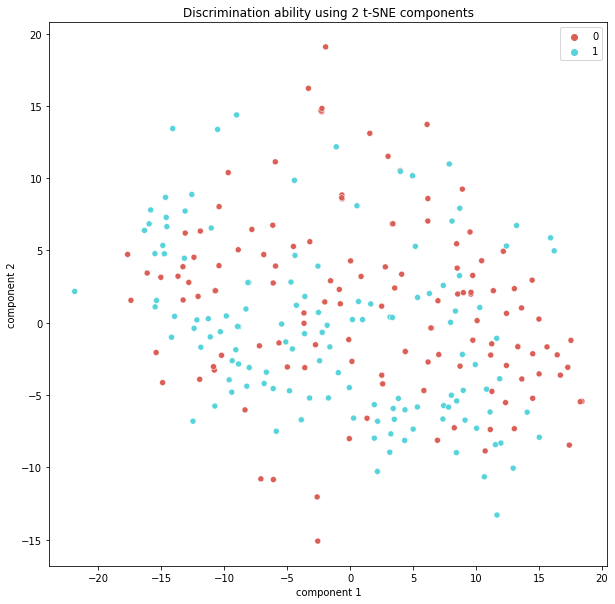

In [10]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=img_target,
    palette=sns.color_palette("hls", 2),
    data=img_data,
    legend="full",
    alpha=1
)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Discrimination ability using 2 t-SNE components')
# plt.colorbar(ticks=np.arange(0, 2))

Slightly different from the PCA plot, we see that the benign tumors tend to have lower competent 2 values, there are very few malignant tumor images at this space in the plot. Other than that observation, there is still very little clustering happening in the t-SNE visualization. It's interesting that in this case, the benign tumors had a lower component 2 value than the malignant tumors, but that distinction is very minimal on both the PCA and t-SNE plots.